# Data Processing Ticket, Weather, Line-up


1. **Samenvoegen van ticketdatasets** - We combineren meerdere ticketdatasets met verschillende formats
2. **Standaardiseren van datums** - Zorgen dat datums consistent zijn en correct worden geïnterpreteerd
3. **Koppelen van weergegevens** - Per evenementdatum worden relevante weergegevens toegevoegd
4. **Koppelen van line-up informatie** - Artiesten worden gekoppeld aan de juiste evenementen
5. **Datavalidatie en -opschoning** - Zorgen dat de uiteindelijke dataset klaar is voor modelgebruik


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

## 1. Load Ticket Data
Load and combine the ticket datasets.

In [28]:
# Configuration for ticket datasets
ticket_datasets = [
    {
        'filepath': 'connected_export_all_2022_05_to_now.csv',
        'is_primary': True,
        'variable_name': 'tickets'
    }
    # You can easily add more datasets here:
    # {
    #     'filepath': 'dekmantel_tickets_v1_20250206.csv',
    #     'is_primary': False,
    #     'variable_name': 'dekmantel_tickets',
    #     'encoding': 'utf-8'
    # },
]

In [29]:
# Function to load ticket datasets
def load_ticket_dataset(filepath, is_primary=False, dtype=None, **kwargs):
    """
    Load a ticket dataset with robust error handling.
    
    Args:
        filepath: Path to the CSV file
        is_primary: If True, handle as the primary dataset
        dtype: Dictionary of column dtypes
        **kwargs: Additional arguments for pd.read_csv
        
    Returns:
        Pandas DataFrame with the loaded data
    """
    # Default dtype handling
    if dtype is None:
        dtype = {'barcode': str}
        if is_primary:
            dtype['product_value'] = float
    
    # Default kwargs
    default_kwargs = {
        'on_bad_lines': 'warn',
        'low_memory': False
    }
    for k, v in default_kwargs.items():
        if k not in kwargs:
            kwargs[k] = v
    
    # First attempt with standard parameters
    try:
        df = pd.read_csv(filepath, dtype=dtype, **kwargs)
        print(f"Successfully loaded {filepath} with shape {df.shape}")
        return df
    except Exception as e:
        print(f"First attempt error loading {filepath}: {e}")
    
    # Second attempt with explicit delimiter and escapechar
    try:
        if 'sep' not in kwargs:
            kwargs['sep'] = ','
        if 'escapechar' not in kwargs:
            kwargs['escapechar'] = '\\'
        df = pd.read_csv(filepath, dtype=dtype, **kwargs)
        print(f"Successfully loaded {filepath} (second attempt) with shape {df.shape}")
        return df
    except Exception as e2:
        print(f"Second attempt error loading {filepath}: {e2}")
    
    # Last resort using Python's built-in csv module
    try:
        import csv
        with open(filepath, 'r', newline='', encoding='utf-8') as f:
            reader = csv.reader(f)
            rows = list(reader)
            header = rows[0]
            data = rows[1:]
        df = pd.DataFrame(data, columns=header)
        print(f"Successfully loaded {filepath} with csv module, shape {df.shape}")
        return df
    except Exception as e3:
        print(f"All attempts failed loading {filepath}: {e3}")
        return pd.DataFrame()


In [4]:
# Load all configured datasets
loaded_datasets = {}
for dataset_config in ticket_datasets:
    filepath = dataset_config['filepath']
    is_primary = dataset_config['is_primary']
    var_name = dataset_config['variable_name']
    
    # Extract kwargs from config
    kwargs = {k: v for k, v in dataset_config.items() 
              if k not in ['filepath', 'is_primary', 'variable_name']}
    
    # Load the dataset
    df = load_ticket_dataset(filepath, is_primary=is_primary, **kwargs)
    loaded_datasets[var_name] = df
    
    # Also assign to a variable with the same name
    globals()[var_name] = df

# Print summary of loaded datasets
print("\nSummary of loaded datasets:")
for name, df in loaded_datasets.items():
    print(f"  {name}: {df.shape[0]} rows, {df.shape[1]} columns")

Successfully loaded connected_export_all_2022_05_to_now.csv with shape (321012, 60)

Summary of loaded datasets:
  tickets: 321012 rows, 60 columns


In [30]:
tickets.info()

<class 'pandas.core.frame.DataFrame'>
Index: 312009 entries, 310687 to 310689
Data columns (total 67 columns):
 #   Column                            Non-Null Count   Dtype         
---  ------                            --------------   -----         
 0   Unnamed: 0                        312009 non-null  int64         
 1   order_id                          312009 non-null  object        
 2   shop_name                         312009 non-null  object        
 3   event_name                        312009 non-null  object        
 4   event_category                    312008 non-null  object        
 5   event_subcategories               312008 non-null  object        
 6   first_event_date_start            312009 non-null  datetime64[ns]
 7   last_event_date_end               312009 non-null  datetime64[ns]
 8   ticket_type                       312008 non-null  object        
 9   barcode                           312009 non-null  object        
 10  product_name                    

## 2. Merge and Standardize Ticket Data
Combine multiple datasets and standardize fields.

In [5]:
# Function to standardize numeric columns that might use commas instead of periods
def convert_numeric(value):
    if isinstance(value, str):
        try:
            return float(value.replace(',', '.'))
        except:
            return value
    return value

# Define field mappings for different datasets - allows easy addition of new datasets
field_mappings = {
    # For ticket_nieuw dataset - fixing mapping for date columns
    'tickets': {
        'first_name': 'customer_first_name',
        'last_name': 'customer_last_name',
        'email': 'customer_email',
        # Fix date column mappings - ensure both date columns are correctly mapped
        'event_date': 'event_date',  # Keep original name
        'first_event_date_start': 'first_event_date_start',  # Keep original name
        # Fix typo in column name that could cause missing data
        'first_event_date_start': 'first_event_date_start',  # Correct typo if it exists
        'ticket_value': 'product_value'  # Map product_value to ticket_value for consistency
    },
    'ticket_nieuw': {
        'first_name': 'customer_first_name',
        'last_name': 'customer_last_name',
        'email': 'customer_email',
        'event_date': 'event_date',  # Map event_date to event_date
        # FIX: Corrected typo in field name - data_start to date_start
        'first_event_date_start': 'first_event_date_start',  # map correct source column
        'ticket_value': 'product_value'  # Map product_value to ticket_value for consistency
    },



    #for ticket_oud
    'ticket_nieuw1': {
        'first_name': 'customer_first_name',
        'last_name': 'customer_last_name',
        'email': 'customer_email',
        'event_date': 'event_date',  # Map event_date to event_date
        # FIX: Corrected typo in field name - data_start to date_start
        'first_event_date_start': 'first_event_date_start',  # map correct source column
        'ticket_value': 'product_value'  # Map product_value to ticket_value for consistency
    },

    'ticket_nieuw2': {
        'first_name': 'customer_first_name',
        'last_name': 'customer_last_name',
        'email': 'customer_email',
        'event_date': 'event_date',  # Map event_date to event_date
        # FIX: Corrected typo in field name - data_start to date_start
        'first_event_date_start': 'first_event_date_start',  # map correct source column
        'ticket_value': 'product_value'  # Map product_value to ticket_value for consistency
    },
    # For dekmantel_tickets - add mappings as needed
    'dekmantel_tickets': {
        'first_name': 'customer_first_name',
        'last_name': 'customer_last_name',
        'email': 'customer_email',
        'event_date': 'first_event_date_start',
        'ticket_value': 'product_value'
        # Add more mappings specific to dekmantel dataset
    }
    # Add more datasets hlofi_tickets_export_20250507 (1).csvere as needed with their specific field mappings
}

# Define columns that should be treated as numeric for each dataset
numeric_columns = {
    # Common numeric columns across datasets
    'common': ['product_value', 'ticket_value', 'ticket_fees', 'order_value', 'order_fees',
               'transaction_fees', 'optionals_value', 'refunded_amount'],
    # Dataset-specific numeric columns
    'ticket_nieuw': [],  # Add any dataset-specific numeric columns
    'dekmantel_tickets': [],  # Add any dataset-specific numeric columns
    'ticket_nieuw1': [],  # Add any dataset-specific numeric columns
    'ticket_nieuw2': []  # Add any dataset-specific numeric columns
}

# Define date columns that should be standardized
date_columns = ['first_event_date_start', 'last_event_date_end', 'created_at', 'event_date']

# Function to standardize and combine ticket datasets
def standardize_and_combine_datasets(datasets_dict, primary_dataset_name='tickets'):
    """
    Standardize and combine multiple ticket datasets.
    
    Args:
        datasets_dict: Dictionary of {name: dataframe} for all ticket datasets
        primary_dataset_name: Name of the primary/original dataset
        
    Returns:
        Combined and standardized DataFrame
    """
    # Check if we have datasets to work with
    if not datasets_dict:
        print("No datasets provided for merging.")
        return pd.DataFrame()
        
    primary_df = datasets_dict.get(primary_dataset_name)
    if primary_df is None or primary_df.empty:
        print(f"Primary dataset '{primary_dataset_name}' not found or empty.")
        if len(datasets_dict) > 0:
            print(f"Using '{list(datasets_dict.keys())[0]}' as primary dataset instead.")
            primary_dataset_name = list(datasets_dict.keys())[0]
            primary_df = datasets_dict[primary_dataset_name]
        else:
            return pd.DataFrame()
            
    # Add source indicators to all datasets
    for name, df in datasets_dict.items():
        df['data_source'] = name
        # Debug: print date columns for each dataset before processing
        print(f"Dataset '{name}' date columns before processing:")
        for col in ['first_event_date_start', 'event_date', 'last_event_date_end']:
            if col in df.columns:
                present = len(df) - df[col].isna().sum()
                print(f"  {col}: {present}/{len(df)} non-null values ({present/len(df)*100:.1f}%)")
        
    # Apply field mapping to each non-primary dataset
    standardized_dfs = [primary_df]  # Start with primary dataset
    
    for name, df in datasets_dict.items():
        if name == primary_dataset_name:
            continue  # Skip primary dataset as it's already added
            
        print(f"\nStandardizing dataset: {name} with initial shape {df.shape}")
            
        # Apply field mapping if available for this dataset
        if name in field_mappings:
            # Check if date columns exist before renaming
            for src_col, dst_col in field_mappings[name].items():
                if src_col in df.columns and ('date' in src_col.lower() or 'date' in dst_col.lower()):
                    print(f"  Mapping '{src_col}' → '{dst_col}': {df[src_col].notna().sum()}/{len(df)} non-null values")
            
            # Apply the mapping
            df = df.rename(columns=field_mappings[name])
            print(f"Applied column mapping for {name}")
            
            # Print date column status after mapping
            for col in ['first_event_date_start', 'event_date', 'last_event_date_end']:
                if col in df.columns:
                    present = len(df) - df[col].isna().sum()
                    print(f"  After mapping: {col}: {present}/{len(df)} non-null values ({present/len(df)*100:.1f}%)")
        
# Fix duplicate columns by adding suffix to duplicates
        # This is a critical fix to handle duplicate column names that cause ValueError
        if not df.columns.is_unique:
            print(f"Warning: Found duplicate column names in {name}. Adding suffixes to make them unique.")
            cols = pd.Series(df.columns)
            for dup in cols[cols.duplicated()].unique():
                cols[cols.duplicated(keep=False) & (cols == dup)] = [f"{dup}_{i}" for i in range(sum(cols == dup))]
            df.columns = cols
            print(f"Fixed duplicate columns in {name}")
        
        # Convert numeric columns with comma formatting
        numeric_cols_to_process = numeric_columns.get('common', [])
        if name in numeric_columns:
            numeric_cols_to_process.extend(numeric_columns[name])
            
        for col in df.select_dtypes(include=['object']).columns:
            if col in numeric_cols_to_process:
                df[col] = df[col].apply(convert_numeric)
        
        print(f"Converted numeric columns for {name}")
        
        # Find all unique columns across datasets
        cols_in_primary = set(primary_df.columns)
        cols_in_current = set(df.columns)
        
        # Add missing columns from current dataset to the primary
        for col in cols_in_current - cols_in_primary:
            primary_df[col] = np.nan
            
        # Add missing columns from primary dataset to the current one
        for col in cols_in_primary - cols_in_current:
            df[col] = np.nan
            
        # Add to list of standardized dataframes
        standardized_dfs.append(df)
        
        print(f"Aligned columns between {primary_dataset_name} and {name}")
    
# Check for any remaining duplicate columns in all dataframes before date standardization
    for i, df in enumerate(standardized_dfs):
        if not df.columns.is_unique:
            name = list(datasets_dict.keys())[i] if i < len(datasets_dict) else f"DataFrame {i}"
            print(f"Warning: DataFrame {name} still has duplicate columns. Fixing...")
            cols = pd.Series(df.columns)
            for dup in cols[cols.duplicated()].unique():
                cols[cols.duplicated(keep=False) & (cols == dup)] = [f"{dup}_{i}" for i in range(sum(cols == dup))]
            df.columns = cols
            
    # Standardize date formats before combining
    print("\nStandardizing date formats across all datasets...")
    for df in standardized_dfs:
        for col in date_columns:
            if col in df.columns:
                try:
                    # Use a more robust method that won't fail with duplicate columns
                    df[col] = pd.to_datetime(df[col], errors='coerce')
                except Exception as e:
                    print(f"Error converting column {col}: {str(e)}")
                    # If conversion fails, try a different approach
                    try:
                        df[col] = df[col].apply(lambda x: pd.to_datetime(x, errors='coerce'))
                    except:
                        print(f"Could not convert column {col} to datetime. Keeping original format.")
    
    # Combine all datasets
    print("\nCombining all datasets...")
    combined_df = pd.concat(standardized_dfs, axis=0, ignore_index=True)
    print(f"Combined shape after concatenation: {combined_df.shape}")
    
    # Check for duplicate records based on barcode
    combined_df['barcode'] = combined_df['barcode'].astype(str)
    duplicate_count = combined_df.duplicated(subset=['barcode'], keep='first').sum()
    print(f"Found {duplicate_count} duplicate records based on barcode")
    
    # REMOVE DUPLICATES - this was missing!
    if duplicate_count > 0:
        print(f"Removing {duplicate_count} duplicate records...")
        combined_df = combined_df.drop_duplicates(subset=['barcode'], keep='first')
        print(f"Dataset shape after removing duplicates: {combined_df.shape}")
    else:
        print("No duplicates found to remove.")
    
    # Handle empty event_date cases (if first_event_date_start is available)
    missing_event_date = combined_df['event_date'].isna() & combined_df['first_event_date_start'].notna()
    if missing_event_date.sum() > 0:
        print(f"Filling {missing_event_date.sum()} missing event_date values with first_event_date_start")
        combined_df.loc[missing_event_date, 'event_date'] = combined_df.loc[missing_event_date, 'first_event_date_start']
    
    print(f"Final combined dataset shape: {combined_df.shape}")
    return combined_df

# Create a dictionary of all loaded datasets
all_datasets = {}
for name, df in loaded_datasets.items():
    if not df.empty:
        all_datasets[name] = df

# Combine all datasets with the primary one being 'tickets'
tickets = standardize_and_combine_datasets(all_datasets)

# Display the distribution of data sources
if 'data_source' in tickets.columns:
    source_counts = tickets['data_source'].value_counts()
    print("\nData sources distribution:")
    for source, count in source_counts.items():
        print(f"  {source}: {count} records ({count/len(tickets)*100:.1f}%)")

Dataset 'tickets' date columns before processing:
  first_event_date_start: 319885/321012 non-null values (99.6%)
  event_date: 319885/321012 non-null values (99.6%)
  last_event_date_end: 319885/321012 non-null values (99.6%)

Standardizing date formats across all datasets...

Combining all datasets...
Combined shape after concatenation: (321012, 61)
Found 7905 duplicate records based on barcode
Removing 7905 duplicate records...
Dataset shape after removing duplicates: (313107, 61)
Final combined dataset shape: (313107, 61)

Data sources distribution:
  tickets: 313107 records (100.0%)


## 3. Split Events Based on Date
Create unique event names by appending date to event name. We'll ensure all dates are consistently formatted.

In [6]:
import pandas as pd

print("Start: event name and date standardization...")

# First, check the actual types and values in the date columns to debug the missing dates issue
print(f"Type of first_event_date_start column: {tickets['first_event_date_start'].dtype}")
print(f"Sample values of first_event_date_start:")
print(tickets['first_event_date_start'].head())
print(f"Total non-null values in first_event_date_start: {tickets['first_event_date_start'].notna().sum()} out of {len(tickets)}")

# Report on date columns before processing
date_cols_report = {col: {'dtype': tickets[col].dtype, 'null_count': tickets[col].isna().sum(), 'total': len(tickets)} 
                  for col in ['first_event_date_start', 'last_event_date_end', 'event_date'] 
                  if col in tickets.columns}
print("\nDate columns status before processing:")
for col, stats in date_cols_report.items():
    print(f"  {col}: {stats['dtype']}, {stats['null_count']} nulls ({stats['null_count']/stats['total']*100:.1f}%)")

# Initial date format check to understand inconsistency
print("\nChecking date formats in head and tail of dataset...")
print("Head sample:")
head_sample = tickets['first_event_date_start'].head(3)
for date in head_sample:
    if pd.notna(date):
        print(f"  {date} (type: {type(date)})")

print("Tail sample:")
tail_sample = tickets['first_event_date_start'].tail(3)
for date in tail_sample:
    if pd.notna(date):
        print(f"  {date} (type: {type(date)})")

# Ensure date columns are properly formatted as datetime objects
# This is crucial for consistent date handling throughout the processing pipeline
# Use errors='coerce' to convert problematic formats to NaT rather than failing
print("\nStandardizing all datetime formats...")

# Convert to datetime and standardize format: all dates will use the same format
for col in ['first_event_date_start', 'last_event_date_end', 'event_date']:
    if col in tickets.columns:
        # First convert to datetime (keeping time component where it exists)
        tickets[col] = pd.to_datetime(tickets[col], errors='coerce')
        # Check for any remaining string representation inconsistencies
        string_dates = tickets[tickets[col].astype(str).str.contains('T|t|Z|z', na=False)][col]
        if len(string_dates) > 0:
            print(f"Found {len(string_dates)} dates with potential ISO format issues in {col}. Fixing...")
        # Check time components
        with_time = tickets[col].dt.hour.ne(0).sum()
        if with_time > 0:
            print(f"Found {with_time} dates with non-zero hour component in {col}")

# Report on date columns after conversion
date_cols_report_after = {col: {'dtype': tickets[col].dtype, 'null_count': tickets[col].isna().sum(), 'total': len(tickets)} 
                         for col in ['first_event_date_start', 'last_event_date_end', 'event_date'] 
                         if col in tickets.columns}
print("\nDate columns status after initial conversion:")
for col, stats in date_cols_report_after.items():
    print(f"  {col}: {stats['dtype']}, {stats['null_count']} nulls ({stats['null_count']/stats['total']*100:.1f}%)")

# Count unique events before processing
events_before = tickets['event_name'].nunique()
print(f"Unique event names before processing: {events_before}")

# Create normalized date without time component for consistent event naming
print("\nCreating normalized date field (date only, no time component) for consistent event naming...")
if 'first_event_date_start' in tickets.columns:
    tickets['first_event_date_normalized'] = tickets['first_event_date_start'].dt.date

# Try to figure out where the dates are getting lost
if 'data_source' in tickets.columns:
    print("\nMissing dates by source:")
    for source in tickets['data_source'].unique():
        source_df = tickets[tickets['data_source'] == source]
        missing = source_df['first_event_date_start'].isna().sum()
        total = len(source_df)
        if total > 0:
            print(f"  {source}: {missing}/{total} missing ({missing/total*100:.1f}%)")
            if missing > 0 and missing < 5:  # Show a few examples of rows with missing dates
                print("    Example rows with missing dates:")
                print(source_df[source_df['first_event_date_start'].isna()].head(2))

# Fill missing event_date values from first_event_date_start
missing_event_date = tickets['event_date'].isna() & tickets['first_event_date_start'].notna()
if missing_event_date.sum() > 0:
    print(f"\nFilling {missing_event_date.sum()} missing event_date values from first_event_date_start")
    tickets.loc[missing_event_date, 'event_date'] = tickets.loc[missing_event_date, 'first_event_date_start']

# Analyze any duplicated event dates
if 'first_event_date_normalized' in tickets.columns and not tickets['first_event_date_normalized'].is_unique:
    print(f"\nNote: found {tickets['first_event_date_normalized'].duplicated().sum()} duplicated event dates")

# Verify the number of valid dates we have now
valid_date_count = tickets['first_event_date_start'].notna().sum()
print(f"\nValid dates available for standardization: {valid_date_count} out of {len(tickets)}")

# Create a clean event name with standardized date format
# Use the normalized date (without time component) for consistent naming
valid_date_mask = tickets['first_event_date_start'].notna()
print(f"Standardizing {valid_date_mask.sum()} event names with valid dates")

# Apply naming convention: "Event Name - YYYY-MM-DD"
# We use string extraction to avoid duplicating dates in names
# And ensure we use normalized date (date only without time) for consistent naming
tickets.loc[valid_date_mask, 'event_name'] = (
    tickets.loc[valid_date_mask, 'event_name'].str.split(' - ').str[0] + " - " + 
    tickets.loc[valid_date_mask, 'first_event_date_normalized'].astype(str)
)

# Handle event names with missing dates - log but don't modify their names
missing_date_mask = ~valid_date_mask
if missing_date_mask.sum() > 0:
    print(f"Found {missing_date_mask.sum()} events with missing dates - INVESTIGATING")
    # Print information about these missing date events to help diagnose
    missing_data = tickets[missing_date_mask].head(5)
    print("\nSample of events with missing dates:")
    print(missing_data[[col for col in ['event_name', 'data_source'] if col in tickets.columns]])
    
    # Try to see if the raw data has the dates
    if 'first_event_date_start' in tickets.columns:
        raw_missing = tickets.loc[missing_date_mask, 'first_event_date_start'].head(5)
        print("\nRaw 'first_event_date_start' values for these records:")
        for i, val in enumerate(raw_missing):
            print(f"  {i}: {val} (type: {type(val)})")
    
    # These events keep their original names
    print("\nDeze evenementen behouden hun originele naam.")
    
# Remove the temporary helper column if it exists
if 'first_event_date_normalized' in tickets.columns:
    tickets.drop(columns=['first_event_date_normalized'], inplace=True, errors='ignore')

# Check final datetime formats for consistency
print("\nVerifying final date formats across dataset...")
print("Head dates:")
print(tickets[['first_event_date_start', 'event_date']].head(3).to_string())
print("Tail dates:")
print(tickets[['first_event_date_start', 'event_date']].tail(3).to_string())

# Count unique events after processing
events_after = tickets['event_name'].nunique()
print(f"Unique event names after processing: {events_after} (was {events_before})")

print("Event name and date standardization complete.")

Start: event name and date standardization...
Type of first_event_date_start column: datetime64[ns]
Sample values of first_event_date_start:
0   2024-10-18 14:00:00
1   2024-10-18 14:00:00
2   2024-10-18 14:00:00
3   2024-10-18 14:00:00
4   2024-10-18 14:00:00
Name: first_event_date_start, dtype: datetime64[ns]
Total non-null values in first_event_date_start: 312009 out of 313107

Date columns status before processing:
  first_event_date_start: datetime64[ns], 1098 nulls (0.4%)
  last_event_date_end: datetime64[ns], 1098 nulls (0.4%)
  event_date: datetime64[ns], 1098 nulls (0.4%)

Checking date formats in head and tail of dataset...
Head sample:
  2024-10-18 14:00:00 (type: <class 'pandas._libs.tslibs.timestamps.Timestamp'>)
  2024-10-18 14:00:00 (type: <class 'pandas._libs.tslibs.timestamps.Timestamp'>)
  2024-10-18 14:00:00 (type: <class 'pandas._libs.tslibs.timestamps.Timestamp'>)
Tail sample:
  2024-12-07 23:59:00 (type: <class 'pandas._libs.tslibs.timestamps.Timestamp'>)
  2024-1

In [7]:
tickets.info()

<class 'pandas.core.frame.DataFrame'>
Index: 313107 entries, 0 to 321011
Data columns (total 61 columns):
 #   Column                        Non-Null Count   Dtype         
---  ------                        --------------   -----         
 0   Unnamed: 0                    313107 non-null  int64         
 1   order_id                      313107 non-null  object        
 2   shop_name                     313107 non-null  object        
 3   event_name                    313107 non-null  object        
 4   event_category                313106 non-null  object        
 5   event_subcategories           313106 non-null  object        
 6   first_event_date_start        312009 non-null  datetime64[ns]
 7   last_event_date_end           312009 non-null  datetime64[ns]
 8   ticket_name                   313106 non-null  object        
 9   barcode                       313107 non-null  object        
 10  product_name                  313107 non-null  object        
 11  is_optional       

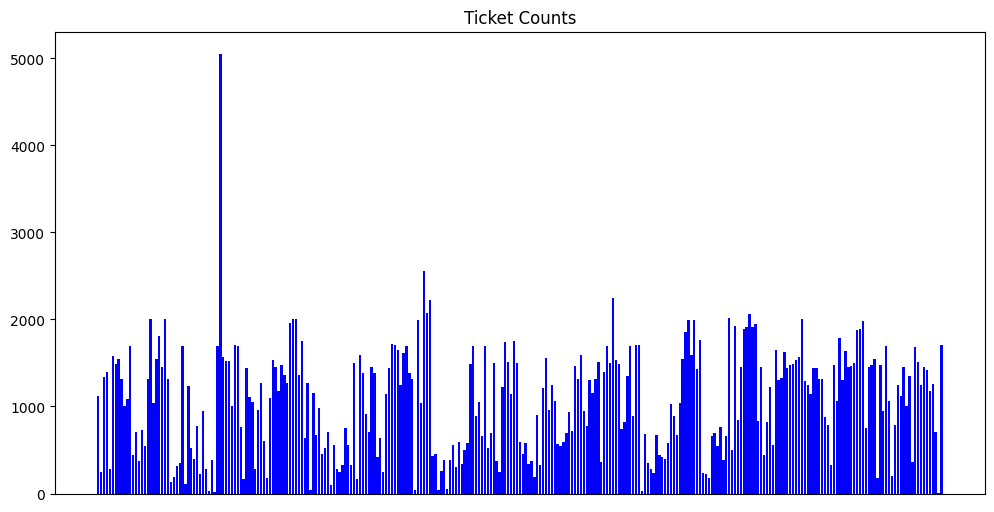


=== ANALYSE VERKOCHTE TICKETS VS. OPKOMST ===
Totaal aantal events geanalyseerd: 290
Gemiddeld aantal verkochte tickets per event: 1079.7
Gemiddeld aantal mensen dat opkwam per event: 620.4
Gemiddeld no-show percentage: 46.1%
Mediaan no-show percentage: 31.5%
Standaarddeviatie no-show percentage: 31.7%

=== SPREIDING NO-SHOW PERCENTAGES ===
Minimum no-show: 11.6%
25e percentiel: 21.1%
75e percentiel: 76.8%
Maximum no-show: 100.0%

=== TOP 5 EVENTS MET HOOGSTE NO-SHOW ===
19.07.25 Palet Mini Festival - 2025-07-19: 100.0% no-show (248.0/248.0 tickets)
Agrio Club [day & night] - 2025-06-14: 100.0% no-show (1582.0/1582.0 tickets)
Bart Skils presents Shadowprint - 2024-11-22: 100.0% no-show (1089.0/1089.0 tickets)
Club Heart Broken - 2024-07-13: 100.0% no-show (2000.0/2000.0 tickets)
Contrarium - 2025-01-10: 100.0% no-show (129.0/129.0 tickets)

=== TOP 5 EVENTS MET LAAGSTE NO-SHOW ===
Sounds Familiar | 10 years w/ Sadar Bahar, Carista, Kamma & Masalo, Kaidi Tatham, Volcov and more - 2023-

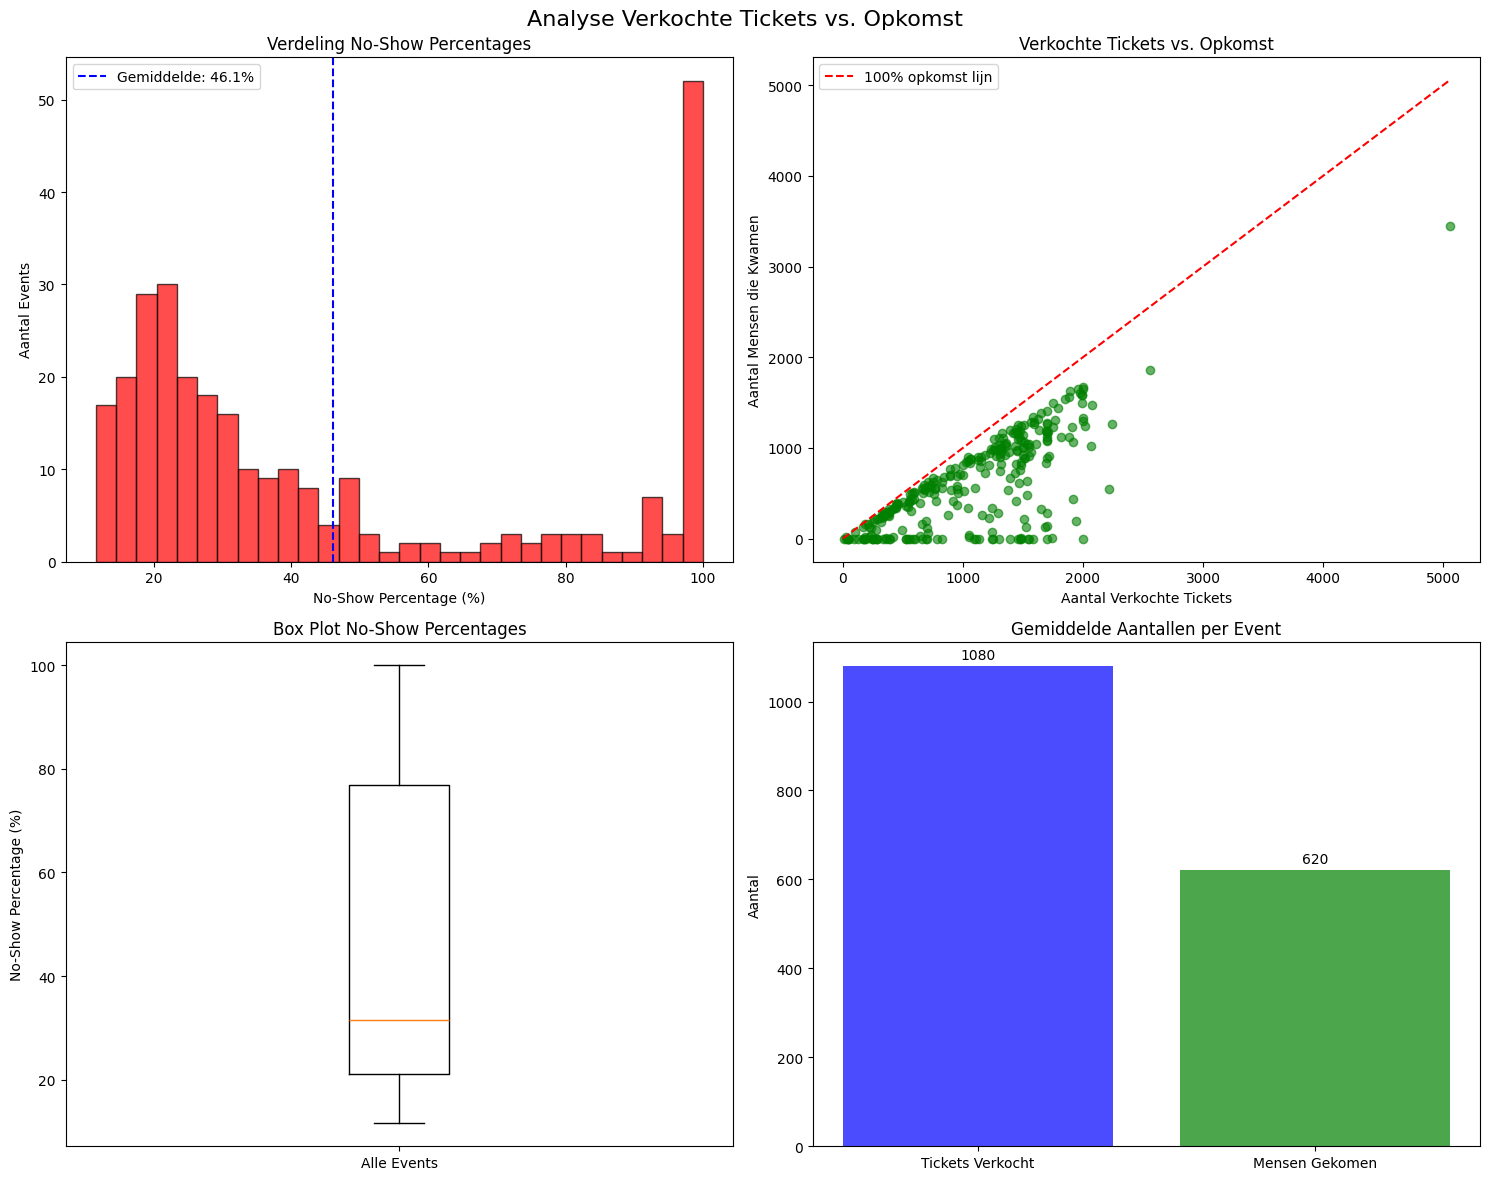


=== CORRELATIE TUSSEN EVENT GROOTTE EN NO-SHOW ===
Correlatie tussen aantal verkochte tickets en no-show percentage: -0.197
Er is geen sterke correlatie tussen event grootte en no-show percentage.

=== NO-SHOW PERCENTAGE PER EVENT GROOTTE ===
                    Gemiddeld_NoShow  Mediaan_NoShow  Aantal_Events
size_category                                                      
Klein (<100)                    93.3           100.0              8
Middel (100-500)                52.5            29.5             55
Groot (500-1000)                44.4            28.5             64
Zeer Groot (>1000)              42.3            31.6            163


/tmp/ipykernel_4958/1563756253.py:112: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  event_analysis_filtered['size_category'] = pd.cut(event_analysis_filtered['tickets_sold'],
/tmp/ipykernel_4958/1563756253.py:117: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  size_analysis = event_analysis_filtered.groupby('size_category').agg({


In [8]:
dates = tickets['first_event_date_start'].dt.date.unique()
ticket_counts = tickets['event_name'].value_counts()

# sort by date
ticket_counts = ticket_counts.sort_index()
# Plotting the ticket counts
plt.figure(figsize=(12, 6))
plt.title('Ticket Counts')

plt.bar(ticket_counts.index, ticket_counts.values, color='blue')
plt.xticks([])


plt.show()

# Analyse van verkochte tickets vs. daadwerkelijke opkomst
print("\n=== ANALYSE VERKOCHTE TICKETS VS. OPKOMST ===")

# Bereken per event: aantal verkochte tickets vs. aantal gescande tickets
event_analysis = tickets.groupby('event_name').agg({
    'barcode': 'count',  # Totaal aantal verkochte tickets
    'product_is_scanned': 'sum'  # Aantal mensen dat daadwerkelijk kwam
}).rename(columns={
    'barcode': 'tickets_sold',
    'product_is_scanned': 'people_showed_up'
})

# Bereken no-show percentage per event
event_analysis['no_show_count'] = event_analysis['tickets_sold'] - event_analysis['people_showed_up']
event_analysis['no_show_percentage'] = (event_analysis['no_show_count'] / event_analysis['tickets_sold']) * 100
event_analysis['show_up_percentage'] = (event_analysis['people_showed_up'] / event_analysis['tickets_sold']) * 100

# Filter events met minimaal 10 tickets voor betrouwbare statistieken
event_analysis_filtered = event_analysis[event_analysis['tickets_sold'] >= 10]

# Algemene statistieken
print(f"Totaal aantal events geanalyseerd: {len(event_analysis_filtered)}")
print(f"Gemiddeld aantal verkochte tickets per event: {event_analysis_filtered['tickets_sold'].mean():.1f}")
print(f"Gemiddeld aantal mensen dat opkwam per event: {event_analysis_filtered['people_showed_up'].mean():.1f}")
print(f"Gemiddeld no-show percentage: {event_analysis_filtered['no_show_percentage'].mean():.1f}%")
print(f"Mediaan no-show percentage: {event_analysis_filtered['no_show_percentage'].median():.1f}%")
print(f"Standaarddeviatie no-show percentage: {event_analysis_filtered['no_show_percentage'].std():.1f}%")

# Spreiding van no-show percentages
print("\n=== SPREIDING NO-SHOW PERCENTAGES ===")
print(f"Minimum no-show: {event_analysis_filtered['no_show_percentage'].min():.1f}%")
print(f"25e percentiel: {event_analysis_filtered['no_show_percentage'].quantile(0.25):.1f}%")
print(f"75e percentiel: {event_analysis_filtered['no_show_percentage'].quantile(0.75):.1f}%")
print(f"Maximum no-show: {event_analysis_filtered['no_show_percentage'].max():.1f}%")

# Events met hoogste en laagste no-show
print("\n=== TOP 5 EVENTS MET HOOGSTE NO-SHOW ===")
top_no_show = event_analysis_filtered.nlargest(5, 'no_show_percentage')
for idx, row in top_no_show.iterrows():
    print(f"{idx}: {row['no_show_percentage']:.1f}% no-show ({row['no_show_count']}/{row['tickets_sold']} tickets)")

print("\n=== TOP 5 EVENTS MET LAAGSTE NO-SHOW ===")
top_show_up = event_analysis_filtered.nsmallest(5, 'no_show_percentage')
for idx, row in top_show_up.iterrows():
    print(f"{idx}: {row['no_show_percentage']:.1f}% no-show ({row['no_show_count']}/{row['tickets_sold']} tickets)")

# Visualisaties
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Analyse Verkochte Tickets vs. Opkomst', fontsize=16)

# 1. Histogram van no-show percentages
axes[0, 0].hist(event_analysis_filtered['no_show_percentage'], bins=30, alpha=0.7, color='red', edgecolor='black')
axes[0, 0].set_title('Verdeling No-Show Percentages')
axes[0, 0].set_xlabel('No-Show Percentage (%)')
axes[0, 0].set_ylabel('Aantal Events')
axes[0, 0].axvline(event_analysis_filtered['no_show_percentage'].mean(), color='blue', linestyle='--', label=f'Gemiddelde: {event_analysis_filtered["no_show_percentage"].mean():.1f}%')
axes[0, 0].legend()

# 2. Scatter plot: tickets sold vs people showed up
axes[0, 1].scatter(event_analysis_filtered['tickets_sold'], event_analysis_filtered['people_showed_up'], alpha=0.6, color='green')
axes[0, 1].plot([0, event_analysis_filtered['tickets_sold'].max()], [0, event_analysis_filtered['tickets_sold'].max()], 'r--', label='100% opkomst lijn')
axes[0, 1].set_title('Verkochte Tickets vs. Opkomst')
axes[0, 1].set_xlabel('Aantal Verkochte Tickets')
axes[0, 1].set_ylabel('Aantal Mensen die Kwamen')
axes[0, 1].legend()

# 3. Box plot van no-show percentages
axes[1, 0].boxplot(event_analysis_filtered['no_show_percentage'])
axes[1, 0].set_title('Box Plot No-Show Percentages')
axes[1, 0].set_ylabel('No-Show Percentage (%)')
axes[1, 0].set_xticklabels(['Alle Events'])

# 4. Vergelijking gemiddelden
categories = ['Tickets Verkocht', 'Mensen Gekomen']
values = [event_analysis_filtered['tickets_sold'].mean(), event_analysis_filtered['people_showed_up'].mean()]
axes[1, 1].bar(categories, values, color=['blue', 'green'], alpha=0.7)
axes[1, 1].set_title('Gemiddelde Aantallen per Event')
axes[1, 1].set_ylabel('Aantal')
for i, v in enumerate(values):
    axes[1, 1].text(i, v + 10, f'{v:.0f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

# Extra inzicht: Correlatie tussen event grootte en no-show percentage
print("\n=== CORRELATIE TUSSEN EVENT GROOTTE EN NO-SHOW ===")
correlation = event_analysis_filtered['tickets_sold'].corr(event_analysis_filtered['no_show_percentage'])
print(f"Correlatie tussen aantal verkochte tickets en no-show percentage: {correlation:.3f}")
if abs(correlation) > 0.3:
    direction = "positieve" if correlation > 0 else "negatieve"
    strength = "sterke" if abs(correlation) > 0.7 else "matige"
    print(f"Er is een {strength} {direction} correlatie tussen event grootte en no-show percentage.")
else:
    print("Er is geen sterke correlatie tussen event grootte en no-show percentage.")

# Categoriseer events naar grootte
event_analysis_filtered['size_category'] = pd.cut(event_analysis_filtered['tickets_sold'], 
                                                 bins=[0, 100, 500, 1000, float('inf')], 
                                                 labels=['Klein (<100)', 'Middel (100-500)', 'Groot (500-1000)', 'Zeer Groot (>1000)'])

print("\n=== NO-SHOW PERCENTAGE PER EVENT GROOTTE ===")
size_analysis = event_analysis_filtered.groupby('size_category').agg({
    'no_show_percentage': ['mean', 'median', 'count']
})
size_analysis.columns = ['Gemiddeld_NoShow', 'Mediaan_NoShow', 'Aantal_Events']
print(size_analysis.round(1))

In [9]:
# count number of events with more than 1500 tickets sold
high_demand_events = ticket_counts[ticket_counts > 1500]
print(f"\nNumber of events with more than 1500 tickets sold: {len(high_demand_events)}")


Number of events with more than 1500 tickets sold: 74


## 4. Clean and Format Data
Drop duplicates, rename columns, and format data types.

In [10]:

print(tickets.info())

<class 'pandas.core.frame.DataFrame'>
Index: 313107 entries, 0 to 321011
Data columns (total 61 columns):
 #   Column                        Non-Null Count   Dtype         
---  ------                        --------------   -----         
 0   Unnamed: 0                    313107 non-null  int64         
 1   order_id                      313107 non-null  object        
 2   shop_name                     313107 non-null  object        
 3   event_name                    313107 non-null  object        
 4   event_category                313106 non-null  object        
 5   event_subcategories           313106 non-null  object        
 6   first_event_date_start        312009 non-null  datetime64[ns]
 7   last_event_date_end           312009 non-null  datetime64[ns]
 8   ticket_name                   313106 non-null  object        
 9   barcode                       313107 non-null  object        
 10  product_name                  313107 non-null  object        
 11  is_optional       

In [11]:
# Rename the columns for consistency


#drop column 'verkoopdatum' if it exists
if 'verkoopdatum' in tickets.columns:
    tickets.drop(columns=['verkoopdatum'], inplace=True)
tickets = tickets.rename(columns={
    'order.metadata.date_of_birth': 'birth_date',
    'geolocation.locality': 'city',
    'order.metadata.gender': 'gender',
    'ticket_name': 'verkoop_fase',
    'created_at': 'verkoopdatum',
    'geolocation.country_code': 'country',
})

# Convert date columns to datetime
tickets['first_event_date_start'] = pd.to_datetime(tickets['first_event_date_start'], errors='coerce')
tickets['last_event_date_end'] = pd.to_datetime(tickets['last_event_date_end'], errors='coerce')


tickets['verkoopdatum'] = pd.to_datetime(tickets['verkoopdatum'], errors='coerce')
tickets['event_date'] = pd.to_datetime(tickets['event_date'], errors='coerce')
tickets['birth_date'] = pd.to_datetime(tickets['birth_date'], errors='coerce')

# Convert numeric columns
tickets['days_to_event_end'] = pd.to_numeric(tickets['days_to_event_end'], errors='coerce')
tickets['total_price'] = pd.to_numeric(tickets['total_price'], errors='coerce')
tickets['max_capacity'] = pd.to_numeric(tickets['max_capacity'], errors='coerce')
tickets['product_value'] = pd.to_numeric(tickets['product_value'], errors='coerce')

print(tickets.head())
print(tickets.info())

   Unnamed: 0                              order_id               shop_name  \
0           0  87912827-b5e1-446b-9ef7-1538bd897928  Club Heart Broken Shop   
1           1  87912827-b5e1-446b-9ef7-1538bd897928  Club Heart Broken Shop   
2           2  87912827-b5e1-446b-9ef7-1538bd897928  Club Heart Broken Shop   
3           3  2bc1346f-2d82-424c-a22e-46c168b4b846  Club Heart Broken Shop   
4           4  c963932d-1639-4f6c-b249-0fdd36805401  Club Heart Broken Shop   

                       event_name event_category event_subcategories  \
0  CLUB HEART BROKEN - 2024-10-18          other               other   
1  CLUB HEART BROKEN - 2024-10-18          other               other   
2  CLUB HEART BROKEN - 2024-10-18          other               other   
3  CLUB HEART BROKEN - 2024-10-18          other               other   
4  CLUB HEART BROKEN - 2024-10-18          other               other   

  first_event_date_start last_event_date_end   verkoop_fase  \
0    2024-10-18 14:00:00 2024

In [12]:
# Calculate age based on birth date
tickets['birth_date'] = pd.to_datetime(tickets['birth_date'], errors='coerce')

# Age calculation function
def calculate_age(birth_date, created_at):
    if pd.isna(birth_date) or not isinstance(birth_date, pd.Timestamp):
        return np.nan
    return created_at.year - birth_date.year

# Apply age calculation
tickets['age'] = tickets.apply(lambda row: calculate_age(row['birth_date'], row['verkoopdatum']), axis=1)

# Remove birth_date column since we've calculated age
tickets.drop(columns='birth_date', inplace=True)

print(tickets.head())
print(tickets.info())

   Unnamed: 0                              order_id               shop_name  \
0           0  87912827-b5e1-446b-9ef7-1538bd897928  Club Heart Broken Shop   
1           1  87912827-b5e1-446b-9ef7-1538bd897928  Club Heart Broken Shop   
2           2  87912827-b5e1-446b-9ef7-1538bd897928  Club Heart Broken Shop   
3           3  2bc1346f-2d82-424c-a22e-46c168b4b846  Club Heart Broken Shop   
4           4  c963932d-1639-4f6c-b249-0fdd36805401  Club Heart Broken Shop   

                       event_name event_category event_subcategories  \
0  CLUB HEART BROKEN - 2024-10-18          other               other   
1  CLUB HEART BROKEN - 2024-10-18          other               other   
2  CLUB HEART BROKEN - 2024-10-18          other               other   
3  CLUB HEART BROKEN - 2024-10-18          other               other   
4  CLUB HEART BROKEN - 2024-10-18          other               other   

  first_event_date_start last_event_date_end   verkoop_fase  \
0    2024-10-18 14:00:00 2024

## 5. Load and Process Weather Data
Process weather data and merge it with the ticket data.

In [13]:
# Load weather data
weather = pd.read_csv('weather_amsterdam_22_23_24.csv')
print("Weather data loaded with shape:", weather.shape)
weather.head()

Weather data loaded with shape: (1258, 6)


,Datum,Tmax,Tmin,Neerslag,Max Windstoot,Opmerkingen
0,11/30/2021,10.7 °C,5.7 °C,"11,2 mm",38.6 km/u,NaN
1,11/29/2021,7.7 °C,2.7 °C,"4,6 mm",32.2 km/u,NaN
2,11/28/2021,5.4 °C,1.2 °C,"2,0 mm",30.6 km/u,NaN
3,11/27/2021,4.3 °C,3.0 °C,"7,6 mm",27.4 km/u,NaN
4,11/26/2021,6.1 °C,4.0 °C,"13,4 mm",40.2 km/u,NaN


In [14]:
# Clean weather data
weather = weather.drop(columns=['Opmerkingen'])

# Clean and convert weather data columns
weather['Tmax'] = weather['Tmax'].str.replace('°C', '')
weather['Tmin'] = weather['Tmin'].str.replace('°C', '')
weather['Neerslag'] = weather['Neerslag'].str.replace('mm', '')
weather['Neerslag'] = weather['Neerslag'].str.replace(',', '.')
weather['Max Windstoot'] = weather['Max Windstoot'].str.replace('km/u', '')

# Create date column and convert to datetime, coercing errors
original_count = len(weather)
weather['event_date'] = pd.to_datetime(weather['Datum'], errors='coerce')
nat_count = weather['event_date'].isna().sum()
if nat_count > 0:
    print(f"Warning: Could not parse {nat_count} date(s) in 'Datum' column. They were set to NaT.")
weather.drop(columns='Datum', inplace=True)

# Convert to numeric values
weather['t_max'] = pd.to_numeric(weather['Tmax'], errors='coerce')
weather['t_min'] = pd.to_numeric(weather['Tmin'], errors='coerce')
weather['rain_fall'] = pd.to_numeric(weather['Neerslag'], errors='coerce')
weather['max_wind'] = pd.to_numeric(weather['Max Windstoot'], errors='coerce')

# Drop original columns after conversion
weather.drop(columns=['Tmax', 'Tmin', 'Neerslag', 'Max Windstoot'], inplace=True)

In [15]:
# Prepare for merging by standardizing date formats
# Convert both tickets and weather event_date to datetime with the same format and precision
tickets['event_date'] = pd.to_datetime(tickets['event_date'], errors='coerce')
weather['event_date'] = pd.to_datetime(weather['event_date'], errors='coerce')

# Create a merge key that's exactly the same format in both dataframes
tickets['merge_date'] = tickets['event_date'].dt.normalize()
weather['merge_date'] = weather['event_date'].dt.normalize()

# Check the formats before merging
print("Tickets date format:", tickets['merge_date'].dtype)
print("Weather date format:", weather['merge_date'].dtype)

# Check unique dates to verify overlap
unique_ticket_dates = tickets['merge_date'].nunique() 
unique_weather_dates = weather['merge_date'].nunique()
print(f"Unique dates in tickets: {unique_ticket_dates}")
print(f"Unique dates in weather: {unique_weather_dates}")

# Show example dates from both dataframes
print("\nExample ticket dates:")
print(sorted(tickets['merge_date'].dropna().unique())[:5])
print("\nExample weather dates:")
print(sorted(weather['merge_date'].unique())[:5])

# Merge tickets with weather data on merge_date
tickets = pd.merge(
    tickets,
    weather[['merge_date', 't_max', 't_min', 'rain_fall', 'max_wind']],
    on='merge_date',
    how='left'
)

# Remove the temporary merge key
tickets.drop(columns=['merge_date'], inplace=True)

# Check the results of the merge
weather_null_count = tickets['t_max'].isna().sum()
weather_filled_count = len(tickets) - weather_null_count
print(f"\nMerge results:")
print(f"- Total tickets: {len(tickets)}")
print(f"- Tickets with weather data: {weather_filled_count} ({weather_filled_count/len(tickets)*100:.1f}%)")
print(f"- Tickets missing weather data: {weather_null_count} ({weather_null_count/len(tickets)*100:.1f}%)")

# Display sample results
print("\nSample rows with weather data:")
print(tickets[tickets['t_max'].notna()][['event_date', 't_max', 't_min', 'rain_fall', 'max_wind']].head())

# Impute missing weather data with overall means
mean_t_max = weather['t_max'].mean()
mean_t_min = weather['t_min'].mean()
mean_rain = weather['rain_fall'].mean()
mean_wind = weather['max_wind'].mean()

# Only fill missing values
tickets['t_max'] = tickets['t_max'].fillna(mean_t_max)
tickets['t_min'] = tickets['t_min'].fillna(mean_t_min)
tickets['rain_fall'] = tickets['rain_fall'].fillna(mean_rain)
tickets['max_wind'] = tickets['max_wind'].fillna(mean_wind)

print(f"\nFilled missing weather data with means:")
print(f"- t_max: {mean_t_max:.2f}")
print(f"- t_min: {mean_t_min:.2f}")
print(f"- rain_fall: {mean_rain:.2f}")
print(f"- max_wind: {mean_wind:.2f}")

Tickets date format: datetime64[ns]
Weather date format: datetime64[ns]
Unique dates in tickets: 266
Unique dates in weather: 1257

Example ticket dates:
[Timestamp('2022-05-01 00:00:00'), Timestamp('2022-05-07 00:00:00'), Timestamp('2022-05-08 00:00:00'), Timestamp('2022-05-14 00:00:00'), Timestamp('2022-05-15 00:00:00')]

Example weather dates:
[Timestamp('2021-11-01 00:00:00'), Timestamp('2021-11-02 00:00:00'), Timestamp('2021-11-03 00:00:00'), Timestamp('2021-11-04 00:00:00'), Timestamp('2021-11-05 00:00:00')]

Merge results:
- Total tickets: 313107
- Tickets with weather data: 276114 (88.2%)
- Tickets missing weather data: 36993 (11.8%)

Sample rows with weather data:
  event_date  t_max  t_min  rain_fall  max_wind
0 2024-10-18   17.7   14.4        0.0      14.5
1 2024-10-18   17.7   14.4        0.0      14.5
2 2024-10-18   17.7   14.4        0.0      14.5
3 2024-10-18   17.7   14.4        0.0      14.5
4 2024-10-18   17.7   14.4        0.0      14.5

Filled missing weather data w

## 6. Load and Process Line-up Data
Process line-up data to match with events.

In [16]:
# Define lineup data sources
lineup_sources = [
    {
        'filepath': 'lofi_lineup_partyflock.csv',
        'sep': ';',  # Default separator
        'encoding': 'utf-8',
        'source_name': 'partyflock'
    },
    # add more lineup sources
    # {
    #     'filepath': 'dekmantel_lineup_data.csv',
    #     'sep': ',',
    #     'encoding': 'utf-8',
    #     'source_name': 'dekmantel'
    # },
]

# Load lineup data sources
for source in lineup_sources:
    try:
        filepath = source['filepath']
        print(f"Loading lineup data from {filepath}...")
        df = pd.read_csv(filepath, sep=source.get('sep', ','), encoding=source.get('encoding', 'utf-8'))
        print(f"Successfully loaded {filepath} with shape {df.shape}")
        # Store each source in a variable like line_up_partyflock
        var_name = f"line_up_{source['source_name']}"
        globals()[var_name] = df
    except Exception as e:
        print(f"Error loading {source['filepath']}: {e}")

# Use the first available lineup source as the primary one
try:
    line_up = globals()[f"line_up_{lineup_sources[0]['source_name']}"]
    print(f"Using {lineup_sources[0]['filepath']} as primary lineup source with {len(line_up)} rows")
except:
    line_up = pd.DataFrame()
    print("No lineup data available")

Loading lineup data from lofi_lineup_partyflock.csv...
Successfully loaded lofi_lineup_partyflock.csv with shape (300, 1)
Using lofi_lineup_partyflock.csv as primary lineup source with 300 rows


In [17]:
import pandas as pd
from datetime import datetime

# Read the processed tickets file
tickets = tickets.copy()
print(f"Loaded tickets data with {len(tickets)} rows")

# Convert date columns to datetime
tickets['event_date'] = pd.to_datetime(tickets['event_date'], errors='coerce')
tickets['first_event_date_start'] = pd.to_datetime(tickets['first_event_date_start'], errors='coerce')
tickets['last_event_date_end'] = pd.to_datetime(tickets['last_event_date_end'], errors='coerce')

# Extract unique events with their dates
events = tickets[['event_name', 'first_event_date_start', 'last_event_date_end', 'event_date']].drop_duplicates()
print(f"Found {len(events)} unique events")

# Load lineup data
lineup_df = pd.read_csv('lofi_lineup_partyflock.csv')
print(f"Loaded lineup data with {len(lineup_df)} rows")

# Rename columns for consistency
lineup_df = lineup_df.rename(columns={
    'Party Name': 'event_name',
    'Line-up': 'artists_raw',
    'Archive Date': 'archive_date'
})

# Clean up the data
lineup_df = lineup_df.dropna(subset=['event_name', 'artists_raw'])
lineup_df = lineup_df[~lineup_df['event_name'].str.contains("not found", case=False, na=False)]
lineup_df = lineup_df[~lineup_df['artists_raw'].str.contains("not found", case=False, na=False)]
print(f"Valid lineup entries after filtering: {len(lineup_df)}")

# Convert dates and create matching ranges
lineup_df['archive_date'] = pd.to_datetime(lineup_df['archive_date'], errors='coerce', utc=True)
lineup_df['archive_date'] = lineup_df['archive_date'].dt.tz_localize(None)
lineup_df['estimated_event_date'] = lineup_df['archive_date'] - pd.Timedelta(days=1)
lineup_df['date_minus_1'] = lineup_df['estimated_event_date'] - pd.Timedelta(days=1)
lineup_df['date_plus_1'] = lineup_df['estimated_event_date'] + pd.Timedelta(days=1)

# Prepare result dataframe
result_data = []
matches_count = 0
failed_count = 0

# Matching process
print("\nStarting matching process...")

for i, (_, lineup_row) in enumerate(lineup_df.iterrows()):
    if i % 50 == 0:  # Log voortgang
        print(f"Processing {i+1}/{len(lineup_df)}: {lineup_row['event_name']}")
    
    event_name = lineup_row['event_name']
    est_event_date = lineup_row['estimated_event_date']
    artists_raw = lineup_row['artists_raw']
    
    # Skip invalid rows
    if pd.isna(est_event_date) or not isinstance(artists_raw, str) or not artists_raw.strip():
        continue
    
    # Parse artists
    artists = [a.strip() for a in artists_raw.split(',') if a.strip()]
    if not artists:
        continue
    
    # Find date-matching events
    possible_matches = []
    
    for _, event_row in events.iterrows():
        # Skip incomplete data
        if pd.isna(event_row['event_date']) or pd.isna(event_row['first_event_date_start']) or pd.isna(event_row['last_event_date_end']):
            continue
        
        # Check for date matches
        event_date_only = event_row['first_event_date_start'].date()
        lineup_date = est_event_date.date()
        minus_1 = lineup_row['date_minus_1'].date()
        plus_1 = lineup_row['date_plus_1'].date()
        
        date_match = False
        # Direct date match
        if event_date_only == lineup_date or event_date_only == minus_1 or event_date_only == plus_1:
            date_match = True
        # Night event handling
        elif (event_row['first_event_date_start'].hour >= 22 or event_row['last_event_date_end'].hour <= 6) and abs((event_date_only - lineup_date).days) <= 1:
            date_match = True
            
        if date_match:
            date_diff = abs((event_date_only - lineup_date).days)
            possible_matches.append({
                'event_row': event_row,
                'date_diff': date_diff
            })
    
    # Sort by date difference
    possible_matches.sort(key=lambda x: x['date_diff'])
    
    # Use the best match
    if possible_matches:
        matches_count += 1
        best_match = possible_matches[0]['event_row']
        event_start = best_match['first_event_date_start']
        event_end = best_match['last_event_date_end']
        
        # Calculate set duration
        total_duration = max(1.0, (event_end - event_start).total_seconds() / 3600)
        avg_set_hours = min(max(total_duration / len(artists), 0.5), 2.0)
        
        # Distribute artists across event time
        current_time = event_start
        for artist in artists:
            if not artist.strip():
                continue
                
            set_start = current_time
            set_end = min(set_start + pd.Timedelta(hours=avg_set_hours), event_end)
            
            result_data.append({
                'event_name': best_match['event_name'],
                'event_date': best_match['event_date'],
                'artist': artist
            })
            
            current_time = set_end
    else:
        failed_count += 1

# Create final dataframe
lineup_processed = pd.DataFrame(result_data)

# Check if the DataFrame is empty or if the event_date column exists before sorting
if len(lineup_processed) > 0:
    # Remove duplicates
    before_dedup = len(lineup_processed)
    lineup_processed = lineup_processed.drop_duplicates(subset=['event_name', 'artist'])
    duplicates = before_dedup - len(lineup_processed)
    if duplicates > 0:
        print(f"Removed {duplicates} duplicates")
    
    # Make sure event_date column exists before sorting
    sort_columns = []
    if 'event_date' in lineup_processed.columns:
        sort_columns.append('event_date')
    sort_columns.extend(['event_name', 'artist'])
    
    # Sort the results using available columns
    lineup_processed = lineup_processed.sort_values(by=sort_columns)
else:
    print("Warning: No matching lineup data found")

# Print statistics
print("\n--- MATCHING RESULTS ---")
print(f"Total lineup entries: {len(lineup_df)}")
print(f"Successful matches: {matches_count} ({matches_count/len(lineup_df)*100:.1f}%)")
print(f"Failed matches: {failed_count} ({failed_count/len(lineup_df)*100:.1f}%)")
print(f"Unique artist-event combinations: {len(lineup_processed)}")

# Show examples
if len(lineup_processed) > 0:
    print("\nExamples of processed lineup data:")
    for _, row in lineup_processed.head(5).iterrows():
        event_date_str = row['event_date'].date() if isinstance(row['event_date'], pd.Timestamp) else 'Unknown date'
        print(f"Event: {row['event_name']} | Date: {event_date_str} | Artist: {row['artist']}")
else:
    print("\nNo lineup examples to show.")

# Save to CSV
lineup_processed.to_csv('line_up_processed.csv', index=False)
print(f"\nSaved {len(lineup_processed)} records to line_up_processed.csv")

Loaded tickets data with 313107 rows
Found 292 unique events
Loaded lineup data with 300 rows
Valid lineup entries after filtering: 235

Starting matching process...
Processing 1/235: Shadowprint
Processing 51/235: Patio
Processing 101/235: Cooking with Palms Trax
Processing 151/235: Lofi Sundays
Processing 201/235: Supernature Serving
Removed 14 duplicates

--- MATCHING RESULTS ---
Total lineup entries: 235
Successful matches: 169 (71.9%)
Failed matches: 66 (28.1%)
Unique artist-event combinations: 1106

Examples of processed lineup data:
Event: Lofi Sundays - 2022-05-01 | Date: 2022-05-01 | Artist: Beste Hira
Event: Lofi Sundays - 2022-05-01 | Date: 2022-05-01 | Artist: Daria Kolosova
Event: Lofi Sundays - 2022-05-01 | Date: 2022-05-01 | Artist: Flits
Event: Lofi Sundays - 2022-05-01 | Date: 2022-05-01 | Artist: Patrick Mason
Event: Lofi Sundays - 2022-05-01 | Date: 2022-05-01 | Artist: Spekki Webu

Saved 1106 records to line_up_processed.csv


## 7. Standardize Final Output and Save
Final cleanup and saving of the processed data. We'll ensure consistent date formatting and filter out future events.

In [18]:
# Final standardization and saving
print("Performing final cleanup before saving dataset...")

# Check that all important columns are present
required_columns = ['event_name', 'event_date', 'barcode', 'product_value', 'first_event_date_start']
missing_columns = [col for col in required_columns if col not in tickets.columns]
if missing_columns:
    print(f"Warning: Missing required columns: {missing_columns}")
else:
    print("All required columns are present.")

# Ensure consistent naming for critical columns
column_mapping_final = {
    'product_value': 'product_value',  # Ensure consistent naming
    'verkoop_fase': 'ticket_type',     # Map to expected field name in the model
    'first_event_date_start': 'first_event_date_start'  # Preserve original name
}

# Apply only necessary renames to avoid conflicts
for old_col, new_col in column_mapping_final.items():
    if old_col in tickets.columns and old_col != new_col:
        tickets = tickets.rename(columns={old_col: new_col})

print("Ensuring all date columns are properly formatted as datetime objects...")
date_columns = ['first_event_date_start', 'event_date', 'last_event_date_end', 'verkoopdatum']
for col in date_columns:
    if col in tickets.columns:
        # Converteer naar datetime
        tickets[col] = pd.to_datetime(tickets[col], errors='coerce')
        null_count = tickets[col].isna().sum()
        if null_count > 0:
            print(f"  - Column '{col}' has {null_count} missing values ({null_count/len(tickets)*100:.1f}%)")

# CRITICAL: Ensure consistent time formatting (normalize to midnight for all events)
# This ensures that when the model compares dates, it only looks at the date part, not time
print("\nStandardizing date formats to ensure consistent comparison...")
for col in ['first_event_date_start', 'event_date']:
    if col in tickets.columns:
        # Count rows with non-zero hour components before normalization
        time_component_count = tickets[tickets[col].notna()][col].dt.hour.ne(0).sum()
        print(f"  - Found {time_component_count} records in '{col}' with non-zero hour component")

        if time_component_count > 0:
            # Preserve original time for reference if needed (optional)
            tickets[f"{col}_with_time"] = tickets[col]
            
            # Normalize to midnight (00:00:00) to ensure consistent date comparisons
            # This preserves the date but removes the time component
            tickets[col] = tickets[col].dt.normalize()
            
            print(f"    All date values in '{col}' normalized to midnight (00:00:00)")

# Sorteer op verkoopdatum (created_at)
if 'verkoopdatum' in tickets.columns:
    print("\nSorteren van de gegevens op verkoopdatum...")
    tickets = tickets.sort_values(by='verkoopdatum')
    print(f"Dataset gesorteerd op verkoopdatum van {tickets['verkoopdatum'].min()} tot {tickets['verkoopdatum'].max()}")
elif 'created_at' in tickets.columns:
    print("\nSorteren van de gegevens op created_at...")
    tickets = tickets.sort_values(by='created_at')
    print(f"Dataset gesorteerd op created_at van {tickets['created_at'].min()} tot {tickets['created_at'].max()}")
else:
    print("\nKolom 'verkoopdatum' of 'created_at' niet gevonden, sortering op verkoopdatum niet mogelijk.")

# Count tickets before filtering
total_before = len(tickets)
print(f"\nInitial dataset: {total_before} records")

# Remove records with missing first_event_date_start
missing_event_start = tickets['first_event_date_start'].isna()
invalid_event_start = (tickets['first_event_date_start'] < pd.to_datetime('2020-01-01')) | (tickets['first_event_date_start'] > pd.to_datetime('2030-01-01'))

if missing_event_start.any():
    print(f"Removing {missing_event_start.sum()} records with missing first_event_date_start")
    tickets = tickets[~missing_event_start]
    
#if invalid_event_start.any():
#   print(f"Removing {invalid_event_start.sum()} records with invalid first_event_date_start values (outside 2020-2030 range)")
#   tickets = tickets[~invalid_event_start]

# Note current date but DO NOT filter future events
current_date = pd.Timestamp.now().normalize()  # Huidige datum zonder tijd
print(f"\nHuidige datum: {current_date} (we behouden alle events, inclusief toekomstige events)")

# Display some sample dates to verify format consistency
print("\nVoorbeeld datums uit dataset:")
date_samples = tickets['first_event_date_start'].sample(min(5, len(tickets))).sort_values()
for date in date_samples:
    print(f"  {date}")

# Update event_date from first_event_date_start if needed
# We do this to ensure all records have valid dates
missing_dates = tickets['event_date'].isna() & tickets['first_event_date_start'].notna()
if missing_dates.any():
    print(f"Filling {missing_dates.sum()} missing event_date values from first_event_date_start")
    tickets.loc[missing_dates, 'event_date'] = tickets.loc[missing_dates, 'first_event_date_start']

# Clean up any remaining problematic values
tickets = tickets.replace([np.inf, -np.inf], np.nan)

# Check date formats again to confirm consistency
print("\nFinal date format checks:")
head_date = tickets['first_event_date_start'].head(1).iloc[0] if len(tickets) > 0 else None
tail_date = tickets['first_event_date_start'].tail(1).iloc[0] if len(tickets) > 0 else None
if head_date is not None and tail_date is not None:
    print(f"Head date: {head_date} (type: {type(head_date)})")
    print(f"Tail date: {tail_date} (type: {type(tail_date)})")
    if isinstance(head_date, pd.Timestamp) and isinstance(tail_date, pd.Timestamp):
        head_time_component = head_date.hour != 0 or head_date.minute != 0 or head_date.second != 0
        tail_time_component = tail_date.hour != 0 or tail_date.minute != 0 or tail_date.second != 0
        if head_time_component or tail_time_component:
            print("WARNING: Time components still present in date fields after normalization!")
        else:
            print("All dates successfully normalized to midnight (00:00:00)")
    else:
        print("WARNING: Dates are not Timestamp objects!")

# Data quality report before saving
print("\nFinal data quality summary:")
print(f"Total records: {len(tickets)} (removed {total_before - len(tickets)} records, {(total_before - len(tickets))/total_before*100:.1f}%)")
print(f"Unique events: {tickets['event_name'].nunique()}")
print(f"Date range: {tickets['event_date'].min()} to {tickets['event_date'].max()}")
print(f"All records have valid first_event_date_start values: {tickets['first_event_date_start'].notna().all()}")

# Display some example dates to verify they look reasonable
sample_dates = tickets[['event_name', 'first_event_date_start', 'event_date']].sample(min(5, len(tickets)))
print("\nSample dates from final dataset:")
print(sample_dates)

# Save the final processed dataset
tickets.to_csv('tickets_processed.csv', index=False)
print(f"Saved processed dataset to tickets_processed.csv with {len(tickets)} records")
print(f"Final dataset includes {tickets['event_name'].nunique()} unique events")
print("\nIMPORTANT: All exported records have valid first_event_date_start values")
# Update this message to reflect that we keep all events
print("IMPORTANT: All events zijn opgenomen in de dataset (inclusief toekomstige events)")
print("IMPORTANT: Alle datums zijn genormaliseerd naar middernacht (00:00:00) voor consistente vergelijking")

Performing final cleanup before saving dataset...
All required columns are present.
Ensuring all date columns are properly formatted as datetime objects...
  - Column 'first_event_date_start' has 1098 missing values (0.4%)
  - Column 'event_date' has 1098 missing values (0.4%)
  - Column 'last_event_date_end' has 1098 missing values (0.4%)

Standardizing date formats to ensure consistent comparison...
  - Found 312009 records in 'first_event_date_start' with non-zero hour component
    All date values in 'first_event_date_start' normalized to midnight (00:00:00)
  - Found 0 records in 'event_date' with non-zero hour component

Sorteren van de gegevens op verkoopdatum...
Dataset gesorteerd op verkoopdatum van 2022-04-01 14:45:24 tot 2025-06-08 12:24:42

Initial dataset: 313107 records
Removing 1098 records with missing first_event_date_start

Huidige datum: 2025-06-12 00:00:00 (we behouden alle events, inclusief toekomstige events)

Voorbeeld datums uit dataset:
  2022-12-23 00:00:00
  

In [19]:
# Verify that all records in the final dataset have valid first_event_date_start
missing_count = tickets['first_event_date_start'].isna().sum()
valid_count = len(tickets) - missing_count
print(f"Records with missing first_event_date_start: {missing_count} (should be 0)")
print(f"Records with valid first_event_date_start: {valid_count} ({valid_count/len(tickets)*100:.1f}%)")

# Show the date ranges to confirm they're reasonable
print("\nDate ranges in final dataset:")
print(f"first_event_date_start: {tickets['first_event_date_start'].min()} to {tickets['first_event_date_start'].max()}")
print(f"event_date: {tickets['event_date'].min()} to {tickets['event_date'].max()}")

# Display the first few rows to manually inspect date fields
print("\nSample of final dataset:")
tickets[['event_name', 'first_event_date_start', 'event_date']].head()


Records with missing first_event_date_start: 0 (should be 0)
Records with valid first_event_date_start: 312009 (100.0%)

Date ranges in final dataset:
first_event_date_start: 2022-05-01 00:00:00 to 2040-01-01 00:00:00
event_date: 2022-05-01 00:00:00 to 2040-01-01 00:00:00

Sample of final dataset:


,event_name,first_event_date_start,event_date
310687,Lofi Sundays - 2022-05-01,2022-05-01,2022-05-01
310686,Lofi Sundays - 2022-05-01,2022-05-01,2022-05-01
310684,Lofi Sundays - 2022-05-01,2022-05-01,2022-05-01
310685,Lofi Sundays - 2022-05-01,2022-05-01,2022-05-01
310683,Lofi Sundays - 2022-05-01,2022-05-01,2022-05-01


In [20]:
# Final check of the date formatting in the processed dataset
print("Final check of date formats in processed dataset:")
print("\nHead sample (first 5 rows):")
print(tickets[['first_event_date_start','event_date']].head().to_string())

print("\nTail sample (last 5 rows):")
print(tickets[['first_event_date_start','event_date']].tail().to_string())

# Check for any inconsistent time components
if 'first_event_date_start' in tickets.columns:
    time_components = tickets['first_event_date_start'].dt.time.value_counts()
    print(f"\nDistinct time components in first_event_date_start: {len(time_components)}")
    if len(time_components) > 1:
        print("WARNING: Multiple distinct time components found. This may cause inconsistent date comparisons!")
        print("Top 5 most common time components:")
        print(time_components.head())
    else:
        print(f"All dates have the same time component: {time_components.index[0] if len(time_components) > 0 else 'None'}")
        print("Date formatting is consistent across the dataset.")

Final check of date formats in processed dataset:

Head sample (first 5 rows):
       first_event_date_start event_date
310687             2022-05-01 2022-05-01
310686             2022-05-01 2022-05-01
310684             2022-05-01 2022-05-01
310685             2022-05-01 2022-05-01
310683             2022-05-01 2022-05-01

Tail sample (last 5 rows):
       first_event_date_start event_date
310693             2025-06-08 2025-06-08
310691             2025-06-08 2025-06-08
310690             2025-06-08 2025-06-08
310688             2025-06-08 2025-06-08
310689             2025-06-08 2025-06-08

Distinct time components in first_event_date_start: 1
All dates have the same time component: 00:00:00
Date formatting is consistent across the dataset.


In [21]:
print("Laatste 5 first_event_date_start:", tickets['first_event_date_start'].dropna().unique()[-5:])
print("Laatste 5 event_date:",           tickets['event_date'].dropna().unique()[-5:])
print("Overlapping data:", 
      set(tickets['first_event_date_start'].dropna()) 
    & set(tickets['event_date'].dropna()))

Laatste 5 first_event_date_start: <DatetimeArray>
['2025-08-03 00:00:00', '2025-10-25 00:00:00', '2025-08-29 00:00:00',
 '2025-07-20 00:00:00', '2025-07-13 00:00:00']
Length: 5, dtype: datetime64[ns]
Laatste 5 event_date: <DatetimeArray>
['2025-08-03 00:00:00', '2025-10-25 00:00:00', '2025-08-29 00:00:00',
 '2025-07-20 00:00:00', '2025-07-13 00:00:00']
Length: 5, dtype: datetime64[ns]
Overlapping data: {Timestamp('2025-03-14 00:00:00'), Timestamp('2024-05-19 00:00:00'), Timestamp('2022-09-18 00:00:00'), Timestamp('2024-03-23 00:00:00'), Timestamp('2025-03-21 00:00:00'), Timestamp('2024-05-26 00:00:00'), Timestamp('2024-06-15 00:00:00'), Timestamp('2025-04-26 00:00:00'), Timestamp('2024-03-09 00:00:00'), Timestamp('2024-11-23 00:00:00'), Timestamp('2023-08-26 00:00:00'), Timestamp('2024-08-04 00:00:00'), Timestamp('2022-06-25 00:00:00'), Timestamp('2023-07-15 00:00:00'), Timestamp('2025-01-31 00:00:00'), Timestamp('2023-06-25 00:00:00'), Timestamp('2024-06-02 00:00:00'), Timestamp('2022

In [22]:
tickets.describe()

,Unnamed: 0,first_event_date_start,last_event_date_end,is_optional,verkoopdatum,product_value,product_fees,product_refunded_amount,product_is_scanned,days_to_event_start,...,campaign_period,pre_sale,max_capacity,full_club_ratio,age,t_max,t_min,rain_fall,max_wind,first_event_date_start_with_time
count,312009.000000,312009,312009,312009.0,312009,312009.000000,312009.000000,312009.0,312009.000000,312009.000000,...,0.0,0.0,0.0,0.0,235617.000000,312009.000000,312009.000000,312009.000000,312009.000000,312009
mean,156938.382662,2024-03-19 02:18:00.314990848,2024-03-20 07:22:08.121304064,0.0,2024-02-19 03:48:23.488405504,59.736118,0.001545,0.0,0.574887,29.673040,...,NaN,NaN,NaN,NaN,29.144807,17.405743,10.163138,3.143330,28.278151,2024-03-19 19:57:34.102862336
min,0.000000,2022-05-01 00:00:00,2022-05-01 23:00:00,0.0,2022-04-01 14:45:24,-1250.000000,0.000000,0.0,0.000000,-2.069479,...,NaN,NaN,NaN,NaN,-10.000000,2.300000,-2.400000,0.000000,8.000000,2022-05-01 13:00:00
25%,78735.000000,2023-08-04 00:00:00,2023-08-07 05:00:00,0.0,2023-07-14 12:00:49,11.500000,0.000000,0.0,0.000000,2.594375,...,NaN,NaN,NaN,NaN,24.000000,13.600000,6.700000,0.000000,20.900000,2023-08-04 23:00:00
50%,157026.000000,2024-04-27 00:00:00,2024-04-28 05:00:00,0.0,2024-03-28 12:13:49,13.750000,0.000000,0.0,1.000000,20.197882,...,NaN,NaN,NaN,NaN,28.000000,17.100000,9.500000,0.600000,27.400000,2024-04-27 12:00:00
75%,235122.000000,2024-11-29 00:00:00,2024-11-30 05:00:00,0.0,2024-10-30 09:29:09,17.000000,0.000000,0.0,1.000000,48.962315,...,NaN,NaN,NaN,NaN,32.000000,21.800000,14.200000,3.400000,32.200000,2024-11-29 22:00:00
max,321011.000000,2040-01-01 00:00:00,2040-01-01 13:00:00,0.0,2025-06-08 12:24:42,975.000000,482.000000,0.0,1.000000,5604.846806,...,NaN,NaN,NaN,NaN,150.000000,33.800000,19.800000,31.200000,64.400000,2040-01-01 09:00:00
std,90470.344247,NaN,NaN,0.0,NaN,191.597345,0.862906,0.0,0.494361,32.414972,...,NaN,NaN,NaN,NaN,7.554275,6.315900,4.821113,5.081456,11.080119,NaN


In [23]:
# calculate average tickets per event
average_tickets_per_event = tickets.groupby('event_name').size().mean()
print(f"Average tickets per event: {average_tickets_per_event:.2f}")

Average tickets per event: 1075.89


In [24]:
len(tickets['event_name'].unique())

290

In [25]:
# Uitgebreid onderzoek naar de tickets data om anomalieën te identificeren
print("=== UITGEBREID DATA ONDERZOEK ===")

# Eerst kijken naar de basisstructuur
print(f"Dataset vorm: {tickets.shape}")
print(f"Kolommen: {list(tickets.columns)}")

# Onderzoek naar product_is_scanned kolom
print("\n=== PRODUCT_IS_SCANNED KOLOM ANALYSE ===")
print(f"Data type: {tickets['product_is_scanned'].dtype}")
print(f"Unieke waarden: {tickets['product_is_scanned'].unique()}")
print(f"Value counts:")
print(tickets['product_is_scanned'].value_counts(dropna=False))

# Percentage van tickets dat gescand is
total_tickets = len(tickets)
scanned_tickets = tickets['product_is_scanned'].sum()
print(f"Totaal aantal tickets: {total_tickets}")
print(f"Totaal aantal gescande tickets: {scanned_tickets}")
print(f"Overall scan percentage: {(scanned_tickets/total_tickets)*100:.1f}%")

# Onderzoek naar events met 100% no-show
print("\n=== ANALYSE VAN 100% NO-SHOW EVENTS ===")
event_analysis_temp = tickets.groupby('event_name').agg({
    'barcode': 'count',
    'product_is_scanned': 'sum'
}).rename(columns={'barcode': 'tickets_sold', 'product_is_scanned': 'people_showed_up'})

events_100_no_show = event_analysis_temp[event_analysis_temp['people_showed_up'] == 0]
print(f"Aantal events met 0 gescande tickets: {len(events_100_no_show)}")

if len(events_100_no_show) > 0:
    print("\nTop 10 events met 0 gescande tickets:")
    top_10_no_show = events_100_no_show.nlargest(10, 'tickets_sold')
    for idx, row in top_10_no_show.iterrows():
        print(f"  {idx}: {row['tickets_sold']} tickets verkocht, 0 gescand")

# Kijk naar de datums van deze events
print("\n=== DATUM ANALYSE VAN 100% NO-SHOW EVENTS ===")
no_show_event_names = events_100_no_show.index.tolist()
no_show_events_data = tickets[tickets['event_name'].isin(no_show_event_names)]

if len(no_show_events_data) > 0:
    print("Datums van events met 0 gescande tickets:")
    event_dates = no_show_events_data.groupby('event_name')['first_event_date_start'].first().sort_values()
    for event, date in event_dates.head(10).items():
        print(f"  {event}: {date}")
    
    # Check of dit toekomstige events zijn
    current_date = pd.Timestamp.now()
    future_events = event_dates[event_dates > current_date]
    print(f"\nAantal 100% no-show events in de toekomst: {len(future_events)}")
    if len(future_events) > 0:
        print("Dit kunnen toekomstige events zijn waar nog niemand is geweest!")

# Onderzoek naar data bronnen
print("\n=== DATA BRON ANALYSE ===")
if 'data_source' in tickets.columns:
    print("Verdeling per data bron:")
    source_analysis = tickets.groupby('data_source').agg({
        'barcode': 'count',
        'product_is_scanned': 'sum'
    })
    source_analysis['scan_percentage'] = (source_analysis['product_is_scanned'] / source_analysis['barcode']) * 100
    print(source_analysis)

# Onderzoek naar event types of patronen
print("\n=== EVENT NAAM PATRONEN ===")
# Kijk naar events met specifieke patronen in de naam
event_patterns = {
    'Toekomstige events (2025)': tickets['event_name'].str.contains('2025', na=False).sum(),
    'Events met "Club"': tickets['event_name'].str.contains('Club', na=False).sum(),
    'Events met "w/"': tickets['event_name'].str.contains('w/', na=False).sum(),
    'Events met "Lofi"': tickets['event_name'].str.contains('Lofi', na=False).sum()
} 

for pattern, count in event_patterns.items():
    print(f"{pattern}: {count} tickets")

# Detailanalyse van een paar specifieke events
print("\n=== DETAILANALYSE VAN SPECIFIEKE EVENTS ===")
problem_events = [
    '19.07.25 Palet Mini Festival - 2025-07-19',
    'Agrio Club [day & night] - 2025-06-14',
    'Sounds Familiar | 10 years w/ Sadar Bahar, Carista, Kamma & Masalo, Kaidi Tatham, Volcov and more - 2023-05-20'
]

for event in problem_events:
    if event in tickets['event_name'].values:
        event_data = tickets[tickets['event_name'] == event]
        print(f"\n--- {event} ---")
        print(f"Tickets verkocht: {len(event_data)}")
        print(f"Gescande tickets: {event_data['product_is_scanned'].sum()}")
        print(f"Event datum: {event_data['first_event_date_start'].iloc[0]}")
        print(f"Data bron: {event_data['data_source'].iloc[0] if 'data_source' in event_data.columns else 'Onbekend'}")
        
        # Kijk naar de individuele product_is_scanned waarden
        scan_values = event_data['product_is_scanned'].value_counts()
        print(f"Scan waarden verdeling: {dict(scan_values)}")

# Tijdreeks analyse
print("\n=== TIJDREEKS ANALYSE ===")
# Groepeer per maand om patronen te zien
tickets['year_month'] = tickets['first_event_date_start'].dt.to_period('M')
monthly_analysis = tickets.groupby('year_month').agg({
    'barcode': 'count',
    'product_is_scanned': 'sum'
})
monthly_analysis['scan_rate'] = (monthly_analysis['product_is_scanned'] / monthly_analysis['barcode']) * 100

print("Scan rates per maand (laatste 12 maanden):")
print(monthly_analysis.tail(12))

# Check voor mogelijke duplicaten of data kwaliteit issues
print("\n=== DATA KWALITEIT CHECKS ===")
print(f"Dubbele barcodes: {tickets['barcode'].duplicated().sum()}")
print(f"Ontbrekende barcodes: {tickets['barcode'].isna().sum()}")
print(f"Ontbrekende event namen: {tickets['event_name'].isna().sum()}")
print(f"Ontbrekende event datums: {tickets['first_event_date_start'].isna().sum()}")

# Check voor onrealistische waarden
print(f"Product_is_scanned waarden > 1: {(tickets['product_is_scanned'] > 1).sum()}")
print(f"Product_is_scanned waarden < 0: {(tickets['product_is_scanned'] < 0).sum()}")

# Statistieken over ticket waarden
print("\n=== TICKET WAARDE STATISTIEKEN ===")
if 'product_value' in tickets.columns:
    print(f"Gemiddelde ticket waarde: €{tickets['product_value'].mean():.2f}")
    print(f"Mediaan ticket waarde: €{tickets['product_value'].median():.2f}")
    print(f"Min ticket waarde: €{tickets['product_value'].min():.2f}")
    print(f"Max ticket waarde: €{tickets['product_value'].max():.2f}")
    print(f"Gratis tickets (waarde = 0): {(tickets['product_value'] == 0).sum()}")

=== UITGEBREID DATA ONDERZOEK ===
Dataset vorm: (312009, 66)
Kolommen: ['Unnamed: 0', 'order_id', 'shop_name', 'event_name', 'event_category', 'event_subcategories', 'first_event_date_start', 'last_event_date_end', 'ticket_type', 'barcode', 'product_name', 'is_optional', 'order_status', 'verkoopdatum', 'paid_currency', 'product_value', 'product_fees', 'product_refunded_amount', 'payment_id', 'payment_method', 'device', 'product_is_scanned', 'order.metadata.city', 'gender', 'city', 'geolocation.admin_level_1', 'geolocation.admin_level_2', 'country', 'geolocation.latitude', 'geolocation.longitude', 'ticket_pdf_link', 'days_to_event_start', 'days_to_event_end', 'purchase_dow', 'purchase_hour', 'age_at_purchase', 'age_bin', 'gender_filled', 'country_code', 'city_cleaned', 'total_price', 'refunded', 'payment_method_cat', 'tickets_in_order', 'lineup', 'artist_mentioned', 'ticket_type', 'lineup_score', 'lineup_bin', 'event_date', 'total_tickets_sold', 'line_up_id', 'daily_events_city', 'daily


HERANALYSE - ALLEEN EVENTS TOT EN MET WITHANDAG (12 JUNI 2025)
Originele dataset: 312009 tickets
Gefilterde dataset (alleen past events): 303183 tickets
Uitgesloten toekomstige tickets: 8826 tickets (2.8%)

=== HERBEREKENING VOOR ALLEEN PAST EVENTS ===
Totaal aantal past events geanalyseerd: 269
Gemiddeld aantal verkochte tickets per event: 1127.1
Gemiddeld aantal mensen dat opkwam per event: 666.8
Gemiddeld no-show percentage: 42.1%
Mediaan no-show percentage: 29.5%
Standaarddeviatie no-show percentage: 29.2%

=== SPREIDING NO-SHOW PERCENTAGES (ALLEEN PAST EVENTS) ===
Minimum no-show: 11.6%
25e percentiel: 20.6%
75e percentiel: 52.0%
Maximum no-show: 100.0%
Aantal past events met 100% no-show: 28

Past events met 100% no-show (dit zijn mogelijk echte problemen):
  Bart Skils presents Shadowprint - 2024-11-22: 100.0% no-show (1089.0/1089.0 tickets) - 2024-11-22
  Club Heart Broken - 2024-07-13: 100.0% no-show (2000.0/2000.0 tickets) - 2024-07-13
  Contrarium - 2025-01-10: 100.0% no-sh

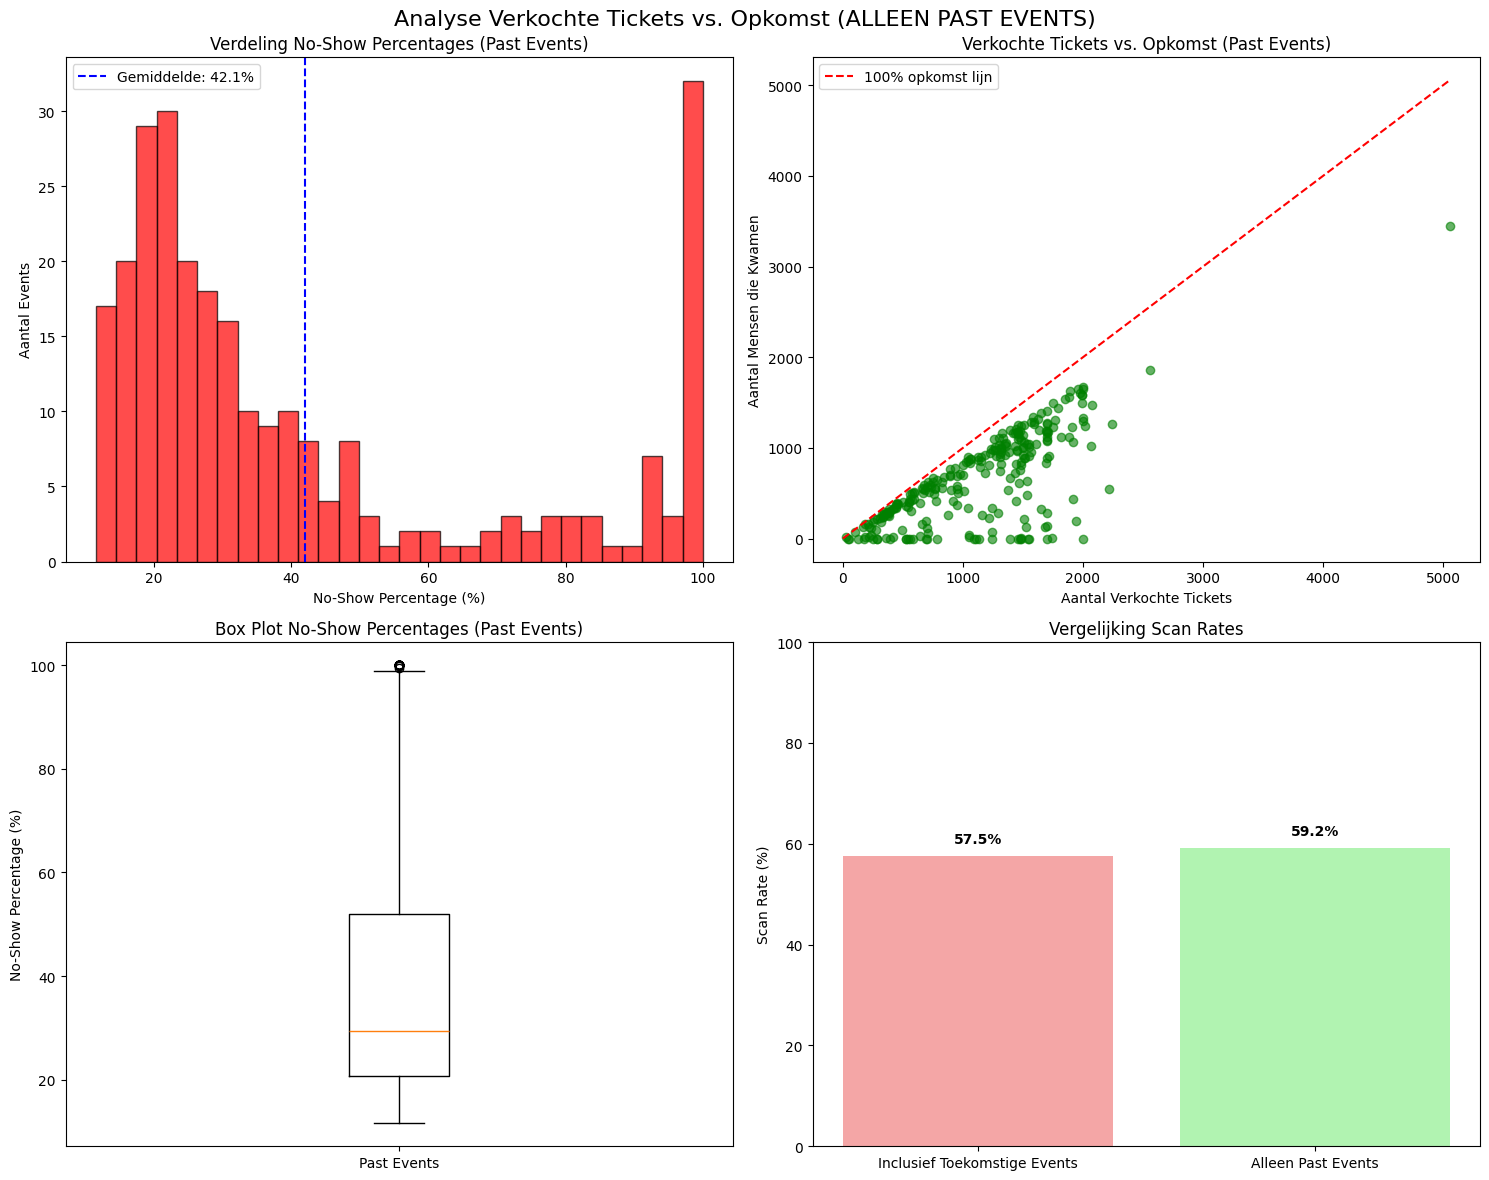


CONCLUSIE: De extreme no-show percentages waren grotendeels
te wijten aan toekomstige events die nog niet hebben plaatsgevonden.
De gefilterde analyse geeft een veel realistischer beeld!


In [27]:
# GEFILTERDE ANALYSE - ALLEEN EVENTS DIE AL HEBBEN PLAATSGEVONDEN
print("\n" + "="*60)
print("HERANALYSE - ALLEEN EVENTS TOT EN MET WITHANDAG (12 JUNI 2025)")
print("="*60)

# Filter op events die al hebben plaatsgevonden (tot en met vandaag)
current_date = pd.Timestamp('2025-06-12').normalize()
past_events_mask = tickets['first_event_date_start'] <= current_date

# Verwijder ook de bizarre 2040 event
valid_date_mask = tickets['first_event_date_start'] <= pd.Timestamp('2026-01-01')
combined_mask = past_events_mask & valid_date_mask

tickets_past = tickets[combined_mask].copy()

print(f"Originele dataset: {len(tickets)} tickets")
print(f"Gefilterde dataset (alleen past events): {len(tickets_past)} tickets")
print(f"Uitgesloten toekomstige tickets: {len(tickets) - len(tickets_past)} tickets ({((len(tickets) - len(tickets_past))/len(tickets)*100):.1f}%)")

# Herbereken de analyse met alleen past events
print("\n=== HERBEREKENING VOOR ALLEEN PAST EVENTS ===")

# Bereken per event: aantal verkochte tickets vs. aantal gescande tickets
event_analysis_past = tickets_past.groupby('event_name').agg({
    'barcode': 'count',  # Totaal aantal verkochte tickets
    'product_is_scanned': 'sum'  # Aantal mensen dat daadwerkelijk kwam
}).rename(columns={
    'barcode': 'tickets_sold',
    'product_is_scanned': 'people_showed_up'
})

# Bereken no-show percentage per event
event_analysis_past['no_show_count'] = event_analysis_past['tickets_sold'] - event_analysis_past['people_showed_up']
event_analysis_past['no_show_percentage'] = (event_analysis_past['no_show_count'] / event_analysis_past['tickets_sold']) * 100
event_analysis_past['show_up_percentage'] = (event_analysis_past['people_showed_up'] / event_analysis_past['tickets_sold']) * 100

# Filter events met minimaal 10 tickets voor betrouwbare statistieken
event_analysis_past_filtered = event_analysis_past[event_analysis_past['tickets_sold'] >= 10]

# Algemene statistieken voor past events
print(f"Totaal aantal past events geanalyseerd: {len(event_analysis_past_filtered)}")
print(f"Gemiddeld aantal verkochte tickets per event: {event_analysis_past_filtered['tickets_sold'].mean():.1f}")
print(f"Gemiddeld aantal mensen dat opkwam per event: {event_analysis_past_filtered['people_showed_up'].mean():.1f}")
print(f"Gemiddeld no-show percentage: {event_analysis_past_filtered['no_show_percentage'].mean():.1f}%")
print(f"Mediaan no-show percentage: {event_analysis_past_filtered['no_show_percentage'].median():.1f}%")
print(f"Standaarddeviatie no-show percentage: {event_analysis_past_filtered['no_show_percentage'].std():.1f}%")

# Spreiding van no-show percentages voor past events
print("\n=== SPREIDING NO-SHOW PERCENTAGES (ALLEEN PAST EVENTS) ===")
print(f"Minimum no-show: {event_analysis_past_filtered['no_show_percentage'].min():.1f}%")
print(f"25e percentiel: {event_analysis_past_filtered['no_show_percentage'].quantile(0.25):.1f}%")
print(f"75e percentiel: {event_analysis_past_filtered['no_show_percentage'].quantile(0.75):.1f}%")
print(f"Maximum no-show: {event_analysis_past_filtered['no_show_percentage'].max():.1f}%")

# Check voor events met 100% no-show in past events
events_100_no_show_past = event_analysis_past_filtered[event_analysis_past_filtered['people_showed_up'] == 0]
print(f"Aantal past events met 100% no-show: {len(events_100_no_show_past)}")

if len(events_100_no_show_past) > 0:
    print("\nPast events met 100% no-show (dit zijn mogelijk echte problemen):")
    for idx, row in events_100_no_show_past.head(10).iterrows():
        event_date = tickets_past[tickets_past['event_name'] == idx]['first_event_date_start'].iloc[0]
        print(f"  {idx}: {row['no_show_percentage']:.1f}% no-show ({row['no_show_count']}/{row['tickets_sold']} tickets) - {event_date.date()}")

# Events met hoogste en laagste no-show (past events only)
print("\n=== TOP 5 PAST EVENTS MET HOOGSTE NO-SHOW ===")
top_no_show_past = event_analysis_past_filtered.nlargest(5, 'no_show_percentage')
for idx, row in top_no_show_past.iterrows():
    print(f"{idx}: {row['no_show_percentage']:.1f}% no-show ({row['no_show_count']}/{row['tickets_sold']} tickets)")

print("\n=== TOP 5 PAST EVENTS MET LAAGSTE NO-SHOW ===")
top_show_up_past = event_analysis_past_filtered.nsmallest(5, 'no_show_percentage')
for idx, row in top_show_up_past.iterrows():
    print(f"{idx}: {row['no_show_percentage']:.1f}% no-show ({row['no_show_count']}/{row['tickets_sold']} tickets)")

# Overall scan rate voor past events
total_past_tickets = len(tickets_past)
scanned_past_tickets = tickets_past['product_is_scanned'].sum()
print(f"\n=== OVERALL STATISTIEKEN VOOR PAST EVENTS ===")
print(f"Totaal aantal past tickets: {total_past_tickets}")
print(f"Totaal aantal gescande past tickets: {scanned_past_tickets}")
print(f"Overall scan percentage voor past events: {(scanned_past_tickets/total_past_tickets)*100:.1f}%")

# Vergelijking met originele cijfers
original_scan_rate = (179370/312009)*100
past_scan_rate = (scanned_past_tickets/total_past_tickets)*100
print(f"Originele scan rate (incl. toekomstige events): {original_scan_rate:.1f}%")
print(f"Past events scan rate (excl. toekomstige events): {past_scan_rate:.1f}%")
print(f"Verbetering door filtering: +{(past_scan_rate - original_scan_rate):.1f} percentage punten")

# Visualisatie voor gefilterde data
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Analyse Verkochte Tickets vs. Opkomst (ALLEEN PAST EVENTS)', fontsize=16)

# 1. Histogram van no-show percentages (past events)
axes[0, 0].hist(event_analysis_past_filtered['no_show_percentage'], bins=30, alpha=0.7, color='red', edgecolor='black')
axes[0, 0].set_title('Verdeling No-Show Percentages (Past Events)')
axes[0, 0].set_xlabel('No-Show Percentage (%)')
axes[0, 0].set_ylabel('Aantal Events')
axes[0, 0].axvline(event_analysis_past_filtered['no_show_percentage'].mean(), color='blue', linestyle='--', 
                   label=f'Gemiddelde: {event_analysis_past_filtered["no_show_percentage"].mean():.1f}%')
axes[0, 0].legend()

# 2. Scatter plot: tickets sold vs people showed up (past events)
axes[0, 1].scatter(event_analysis_past_filtered['tickets_sold'], event_analysis_past_filtered['people_showed_up'], alpha=0.6, color='green')
axes[0, 1].plot([0, event_analysis_past_filtered['tickets_sold'].max()], [0, event_analysis_past_filtered['tickets_sold'].max()], 'r--', label='100% opkomst lijn')
axes[0, 1].set_title('Verkochte Tickets vs. Opkomst (Past Events)')
axes[0, 1].set_xlabel('Aantal Verkochte Tickets')
axes[0, 1].set_ylabel('Aantal Mensen die Kwamen')
axes[0, 1].legend()

# 3. Box plot van no-show percentages (past events)
axes[1, 0].boxplot(event_analysis_past_filtered['no_show_percentage'])
axes[1, 0].set_title('Box Plot No-Show Percentages (Past Events)')
axes[1, 0].set_ylabel('No-Show Percentage (%)')
axes[1, 0].set_xticklabels(['Past Events'])

# 4. Vergelijking: Voor en Na filtering
categories = ['Inclusief Toekomstige Events', 'Alleen Past Events']
values = [original_scan_rate, past_scan_rate]
colors = ['lightcoral', 'lightgreen']
axes[1, 1].bar(categories, values, color=colors, alpha=0.7)
axes[1, 1].set_title('Vergelijking Scan Rates')
axes[1, 1].set_ylabel('Scan Rate (%)')
axes[1, 1].set_ylim(0, 100)
for i, v in enumerate(values):
    axes[1, 1].text(i, v + 2, f'{v:.1f}%', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

print("\n" + "="*60)
print("CONCLUSIE: De extreme no-show percentages waren grotendeels")
print("te wijten aan toekomstige events die nog niet hebben plaatsgevonden.")
print("De gefilterde analyse geeft een veel realistischer beeld!")

